In [45]:
import os
import pathlib
try:
    import pickle5 as pickle
except Exception:
    import pickle

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import plaidml.keras 
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_addons as tfa


SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [3]:
tf.__version__

'2.6.0'

In [ ]:
# unlock GPU
# plaidml.keras.install_backend()
# os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'

## Load Audio Dataset

In [ ]:
checkpoint_path = 'data/features/df.pkl'
with open(checkpoint_path, 'rb') as f:
    df = pickle.load(f)

extract_limit = df.extract_limit.values[0]  # previously found good audio limit
sr = int(df.sr.values[0]) # sample rate

print('sample rate: ', sr)
print('extract limit: ', extract_limit, ' in secs: ', extract_limit / sr)

2021-12-13 15:43:05.835458: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


sample rate:  22050
extract limit:  110250  in secs:  5.0


## Spectrogram with Tensorflow

In [ ]:
sample = df.audio.values[0]
print(len(sample))
waveform = tf.convert_to_tensor(sample)
print(waveform.dtype)

125465
<dtype: 'float32'>


In [93]:
def get_spectrogram(waveform, input_len: int, frame_length=255, frame_step=128, fft_length=None):
    """Create a spectrogram from a waveform of limit size. 
    
    If the waveform exceeds this threshold, it is truncated, 
    if it less than this size the spectorgram is zero padded."""
    waveform = waveform[:input_len]
    waveform = tf.cast(waveform, dtype=tf.float32)
    
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    zero_padding = tf.zeros([input_len] - tf.shape(waveform), dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    
    spectrogram = tf.signal.stft(equal_length, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)
    spectrogram = tf.abs(spectrogram)
    
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    return spectrogram[..., tf.newaxis]


In [ ]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
        
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height, width = log_spec.shape
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [ ]:
spectrogram = get_spectrogram(waveform, input_len=sr)

waveform.shape, spectrogram.shape

(TensorShape([125465]), TensorShape([171, 129, 1]))

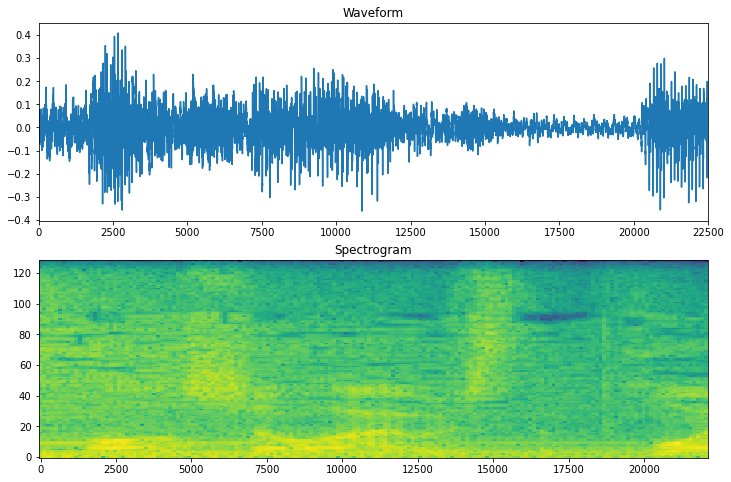

In [19]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 22500])

plot_spectrogram(spectrogram, axes[1])
axes[1].set_title('Spectrogram')
plt.show()

## Prototype

In [94]:

# Short-time fourier transform (STFT) 
# explainer: https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe
frame_length = 255  # window length in number of samples (M), should be odd 
frame_step = 128    # hop size in number of samples
fft_length = None   # size of FFT (N), if None computed automatically

length = sr * 1   # up to extract limit of 5X sr
df['spectrogram'] = df.audio.apply(lambda wav: get_spectrogram(wav, length, frame_length, frame_step, fft_length))  

In [95]:
df.to_pickle(checkpoint_path, protocol=4)

In [96]:
# X = np.array([np.asarray(x).astype('float32') for x in df.spectrogram])

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, df.negativity.values, test_size=0.2, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=SEED)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(10960, 171, 129, 1) (10960,)
(1370, 171, 129, 1) (1370,)
(1370, 171, 129, 1) (1370,)


In [98]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [99]:
for spectrogram, label in train_ds.take(1):
    input_shape = spectrogram.shape
    print(input_shape)

(171, 129, 1)


In [100]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

# reduce read latency while training the model
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

## Model

In [101]:
def get_cnn_model():
    norm_layer = layers.Normalization()
    norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))
    
    num_labels = 2
    return models.Sequential([
        layers.Input(shape=input_shape),
        layers.Resizing(32, 32),  # downsample 
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels),
    ])

In [102]:
model = get_cnn_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_8 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_8 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 12544)            

In [103]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

In [104]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3), 
    use_multiprocessing=True
)

Epoch 1/10
172/172 [==============================] - 9s 52ms/step - loss: 0.9190 - accuracy: 0.5204 - val_loss: 0.6273 - val_accuracy: 0.6423
Epoch 2/10
172/172 [==============================] - 9s 51ms/step - loss: 0.6232 - accuracy: 0.5087 - val_loss: 0.6243 - val_accuracy: 0.5912
Epoch 3/10
172/172 [==============================] - 9s 54ms/step - loss: 0.6314 - accuracy: 0.5341 - val_loss: 0.6364 - val_accuracy: 0.6577
Epoch 4/10
172/172 [==============================] - 11s 62ms/step - loss: 0.6159 - accuracy: 0.5306 - val_loss: 0.6236 - val_accuracy: 0.6365
Epoch 5/10
172/172 [==============================] - 9s 52ms/step - loss: 0.6043 - accuracy: 0.5264 - val_loss: 0.6300 - val_accuracy: 0.6263
Epoch 6/10
172/172 [==============================] - 9s 53ms/step - loss: 0.6170 - accuracy: 0.5201 - val_loss: 0.6345 - val_accuracy: 0.3956
Epoch 7/10
172/172 [==============================] - 9s 52ms/step - loss: 0.6083 - accuracy: 0.5272 - val_loss: 0.6278 - val_accuracy: 0.675

Using 'accuracy' we get a val_loss around 0.66

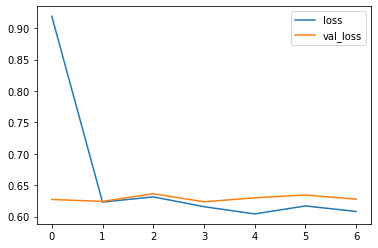

In [105]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

# Evaluate the model performance

In [106]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
y_true = np.array(test_labels)

In [107]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [108]:
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 68%


### Confusion matrix

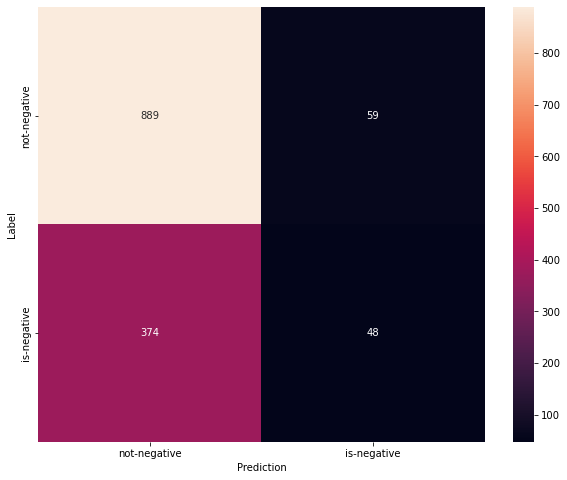

In [109]:
categories = ['not-negative', 'is-negative']
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=categories,
            yticklabels=categories,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show();

In [110]:
from sklearn.metrics import f1_score

f1_score(y_true, y_pred)

0.18147448015122872

Using metrics=['accuracy'] yields: 

loss: 0.5808 - accuracy: 0.6371 - val_loss: 0.6521 - val_accuracy: 0.6642